In [1]:
%matplotlib inline
import os
import os.path as osp
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

root_dir = osp.join(os.getcwd(), '..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

from reid.datasets import get_dataset
from reid.features import extract_features
from reid.mining import mine_hard_triplets
from reid.metrics import pairwise_distance
from reid.models import ResNet
from reid.evaluators import Evaluator
from reid.utils.data import transforms
from reid.utils.data.preprocessor import Preprocessor
from reid.utils.serialization import load_checkpoint, copy_state_dict

In [2]:
# Global configs

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

cudnn.benchmark = True

In [3]:
# Data

dataset_name = 'market1501'
batch_size = 32

data_root = osp.join(root_dir, 'examples', 'data', dataset_name)

dataset = get_dataset('market1501', data_root, split_id=0, num_val=100, download=True)

data_loader = DataLoader(
    Preprocessor(dataset.val, root=dataset.images_dir,
                 transform=transforms.Compose([
                     transforms.RectScale(256, 256),
                     transforms.CenterCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
                 ])),
    batch_size=batch_size, num_workers=1,
    shuffle=False, pin_memory=False)

Files already downloaded and verified
Market1501 dataset loaded
  subset  | # ids | # images
  -------------------------
  train   |   651 |    11387
  val     |   100 |     1549
  query   |   750 |    16483
  gallery |   751 |    19281


In [4]:
# Model

stage1_model = ResNet(50, num_classes=0, num_features=128, norm=True, dropout=0.5)

checkpoint = load_checkpoint(osp.join(root_dir,
    'examples/logs/id/resnet-market1501-oim-31.5-58.6-78.6/model_best.pth.tar'))

stage1_model = copy_state_dict(checkpoint['state_dict'], stage1_model, strip='module.')

=> Loaded checkpoint '/home/cysu/Documents/program/open-reid/notebooks/../examples/logs/id/resnet-market1501-oim-31.5-58.6-78.6/model_best.pth.tar'


In [5]:
# Top predictions

query, gallery = dataset.val, dataset.val
features = extract_features(torch.nn.DataParallel(stage1_model).cuda(), data_loader)
distmat = pairwise_distance(features, dataset.val, dataset.val)
distmat = distmat.cpu().numpy()

indices = np.argsort(distmat, axis=1)

hard_query = []
for i, (_, query_id, query_cam) in enumerate(query):
    for j in indices[i]:
        _, gallery_id, gallery_cam = gallery[j]
        if gallery_id == query_id and gallery_cam == query_cam: continue
        if gallery_id != query_id:
            hard_query.append(i)
        break

Extract Features: [1/49]	Time 4.147 (4.147)	Data 0.126 (0.126)	
Extract Features: [2/49]	Time 0.158 (2.153)	Data 0.004 (0.065)	
Extract Features: [3/49]	Time 0.157 (1.488)	Data 0.002 (0.044)	
Extract Features: [4/49]	Time 0.157 (1.155)	Data 0.001 (0.033)	
Extract Features: [5/49]	Time 0.169 (0.958)	Data 0.004 (0.027)	
Extract Features: [6/49]	Time 0.156 (0.824)	Data 0.002 (0.023)	
Extract Features: [7/49]	Time 0.159 (0.729)	Data 0.003 (0.020)	
Extract Features: [8/49]	Time 0.161 (0.658)	Data 0.003 (0.018)	
Extract Features: [9/49]	Time 0.160 (0.603)	Data 0.003 (0.016)	
Extract Features: [10/49]	Time 0.157 (0.558)	Data 0.002 (0.015)	
Extract Features: [11/49]	Time 0.157 (0.522)	Data 0.002 (0.014)	
Extract Features: [12/49]	Time 0.156 (0.491)	Data 0.002 (0.013)	
Extract Features: [13/49]	Time 0.157 (0.465)	Data 0.002 (0.012)	
Extract Features: [14/49]	Time 0.156 (0.443)	Data 0.002 (0.011)	
Extract Features: [15/49]	Time 0.158 (0.424)	Data 0.002 (0.011)	
Extract Features: [16/49]	Time 0.1

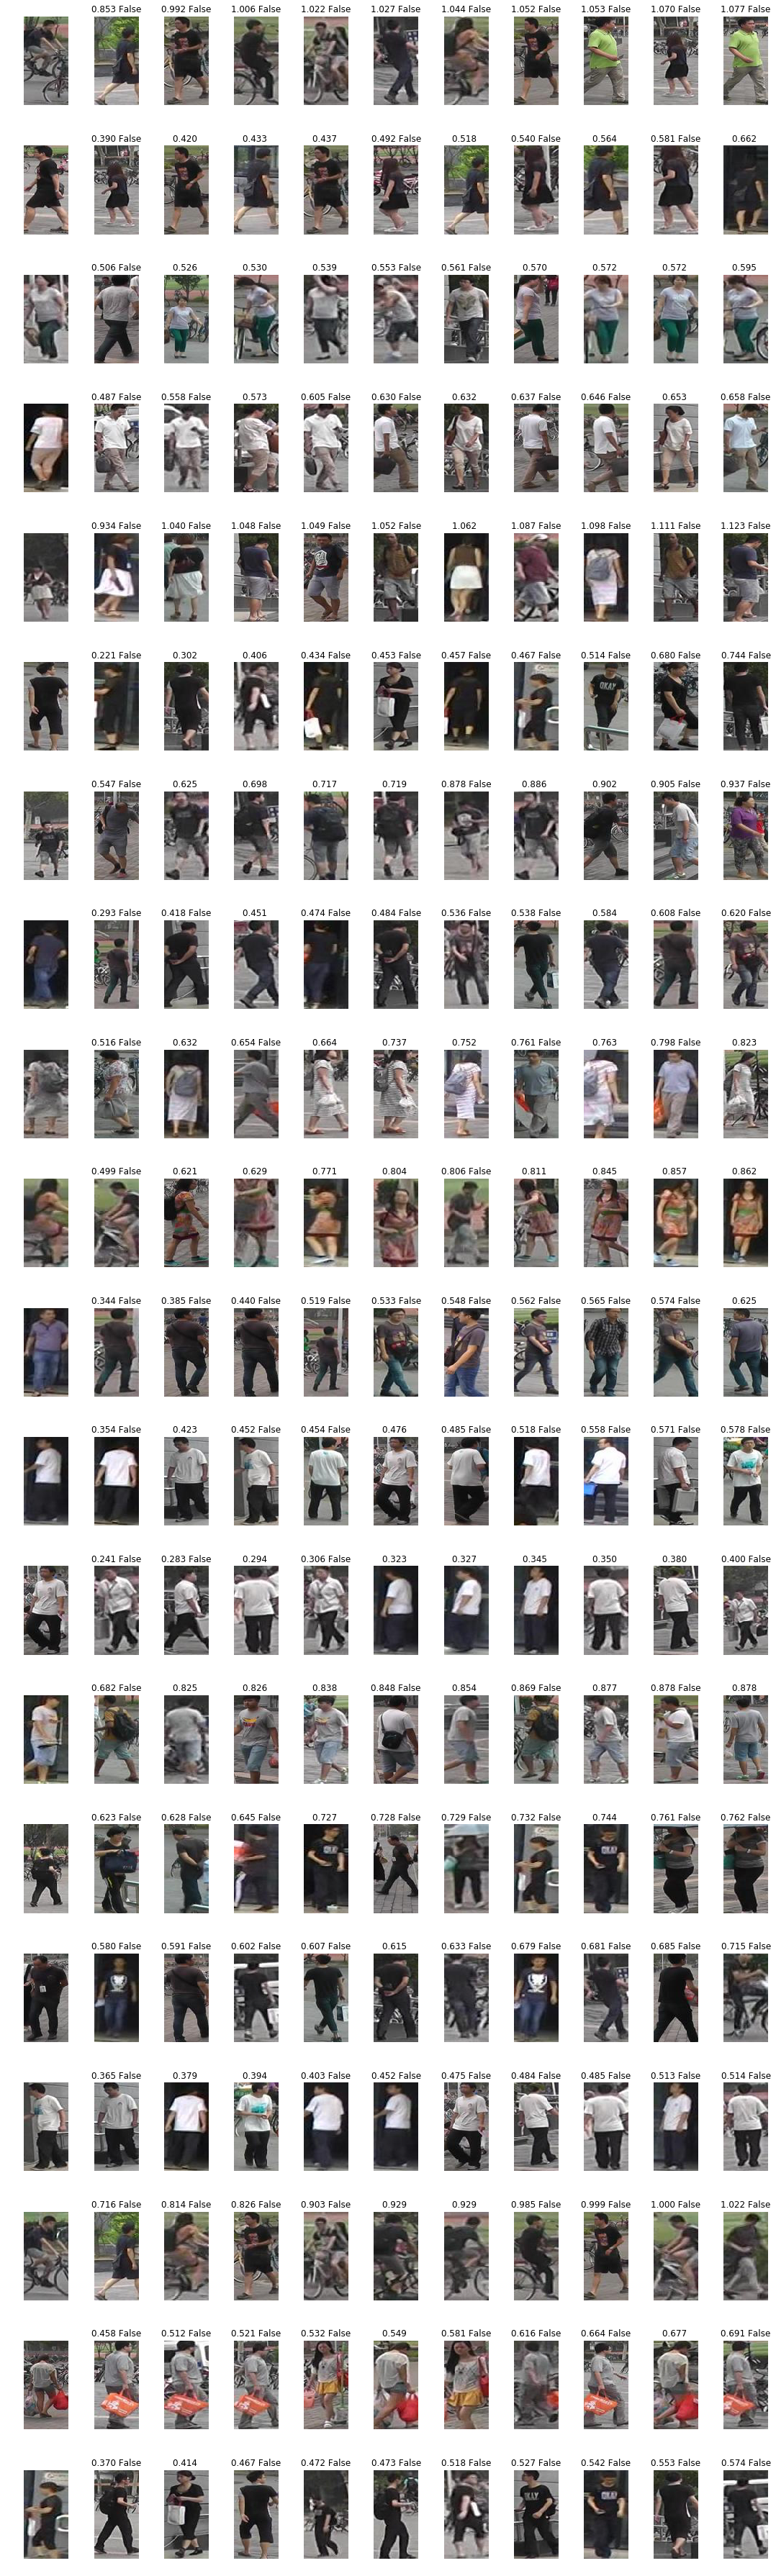

In [10]:
fig, axes = plt.subplots(num_display, topk + 1)
fig.set_figheight(50)
fig.set_figwidth(15)

if axes.ndim == 1:
    axes = axes[np.newaxis, :]
for ax in axes.ravel():
    ax.set_axis_off()
num_display, topk = 20, 10

chosen_query = np.random.choice(hard_query, num_display, replace=False)
for r, i in enumerate(chosen_query):
    fname, query_id, query_cam = query[i]
    axes[r, 0].imshow(plt.imread(osp.join(dataset.images_dir, fname)))
    k = 0
    for c, j in enumerate(indices[i]):
        fname, gallery_id, gallery_cam = gallery[j]
        if query_id == gallery_id and query_cam == gallery_cam: continue
        axes[r, k+1].imshow(plt.imread(osp.join(dataset.images_dir, fname)))
        axes[r, k+1].title.set_text('{:.3f} {}'.format(distmat[i][j], '' if query_id == gallery_id else 'False'))
        k += 1
        if k >= topk: break

fig.tight_layout()

In [ ]:
# Mine hard triplets
triplets = mine_hard_triplets(torch.nn.DataParallel(stage1_model).cuda(),
                              data_loader, margin=0)
print("Mined {} hard triplets".format(len(triplets)))

In [ ]:
# Show some examples

query, gallery = dataset.val, dataset.val

a, p, n = triplets[np.random.choice(len(triplets))]
a, p, n = query[a][0], gallery[p][0], gallery[n][0]

fig, axes = plt.subplots(1, 3)
for ax in axes:
    ax.set_axis_off()
axes[0].imshow(plt.imread(osp.join(dataset.images_dir, a)))
axes[1].imshow(plt.imread(osp.join(dataset.images_dir, p)))
axes[2].imshow(plt.imread(osp.join(dataset.images_dir, n)))

print(a, p, n)